# Homework 2: YOLO

Credit: Saathvik Selvan, Andrew Goldberg, Tim Xie, Aryan Jain

In lecture, we saw this fully convolutional neural network that was capable of performing object detection with a single forward pass and, as such, was significantly faster than prior R-CNN based approaches. This approach was called YOLO and in this homework, we will implement a basic version of it!

We highly recommend going over the Object Detection lecture before you attempt this homework.

**Please make a copy of this notebook and work on it instead of this notebook. The copy will be owned by you and this will ensure that any changes you make to it will get saved.**

Please also change your Colab runtime to CPU (go to Runtime -> Change Runtime Type -> choose CPU). You should use CPU mode while you are reading through the notebook and debugging and only switch to GPU mode once you are confident enough to start a long model training session.

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


In [2]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as TF
from torchvision import models, datasets
from torchvision import tv_tensors

from tqdm.notebook import tqdm

import einops
import numpy as np
from matplotlib import pyplot as plt
from random import randint

import torchvision.datasets as dset
import json
from PIL import Image, ImageDraw

from itertools import product

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Part 1: Loading VOC Dataset

In this homework, we will work with the Pascal VOC dataset. It's a small-scale object detection dataset that was used in the early days for benchmarking object detection models. You can learn more about it [here](http://host.robots.ox.ac.uk/pascal/VOC/).

Before we load in the actual dataset, we specify some important parameters:

`S`: The number of cells we break our image into along the x and y axis (so this gives us an `S x S` grid with $S^2$ cells total).

`B`: The number of detections per cell (we let our model predict up to `B` boxes per cell since it's possible multiple objects are centered in the same cell)

`C`: The number of classes that each object in this dataset could belong to (Pascal VOC has 20 labels)

In [3]:
S, B, C = 7, 2, 20

The VOC Dataset has the data we need, but not in the right format. So we create our own custom dataset which returns the labels in the right format for us to judge our model predictions against (both the ground truth labels and the model predictions will have the same format).

**What is the format of our ground truth labels and model predictions?**

Each image can be broken into $S^2$ cells (49 in our case), and we predict up to $B$ boxes (2 in our case) that could be centered around each cell.

When we predict a box within a cell, we predict the box center $(x, y)$ within the cell as proportions of the cell width but we also predict the box width ($w$) and height ($h$) as a proportion of the full image size.

We also predict a confidence score for each box (within each cell) which represents how confident our model is that an object is actually present within said box: this will be a number in the range [0, 1] and we will more concretely define "confidence" later.

Finally, we predict the class label, encoded as a vector of probabilities (of length $C$), of the object centered around a cell (if there is any). Note that we are only predicting one class per cell instead of one class per bounding box: this was a design choice made by the authors of YOLO that effectively constrains a cell to detect at most 1 object.

Why would you want to predict multiple boxes per cell if they are gonna belong to the same object/class anyways? The idea is that this makes each box "specialize" in some way (say, one box gets better at predicting bounding boxes that are tall rectangles and another might get better at predicing wide rectangles) so during inference time, we can pick the "best" shaped one (we will talk more about this process later).

So, each time we make a prediction on an image, we predict `B` bounding boxes and a `C`-length vector of probabilities for each cell in our `S x S` grid. Each bounding box has 5 numbers associated with it: in order, these are the confidence score `s` (note the lowercase s here), the bounding box center `x` and `y` (relative to the cell) and bounding width `w` and height `h` (relative to the image). In other words, we predict a `5B + C` dimensional vector for each cell so the final output for a single image will have shape `(S, S, 5B + C)` --- when considering a batch of images, the output for that batch will have shape `(batch_size, S, S, 5B + C)`.

In [4]:
class VOCDataset(Dataset):
    def __init__(self, orig_dataset, classes, transform=None):
      self.orig_dataset = orig_dataset
      self.classes = classes
      self.transform = transform

    def __len__(self):
        """
        When you inherit from Dataset you always need to specify a __len__ method.
        Otherwise, how would your DataLoader know when to stop!?
        """
        return len(self.orig_dataset)

    def _get_normalised_box(self, idx, obj, img_size: tuple[int, int]):
        """
        The VOCDataset has boxes in an xmin, ymin, xmax, ymax format, but we need our boxes
        to be in the YOLO format which is an (x, y) representing the center and
        the width and height of the box.
        We return the converted box and the cell (x, y) which the box is centered in
        """
        x_min, y_min, x_max, y_max = obj

        cell_width, cell_height = img_size[0] / S, img_size[1] / S

        box_center_x, box_center_y = (x_max - x_min) / 2 + x_min, (y_max - y_min) / 2 + y_min
        cell_num_x, cell_num_y = int(box_center_x // cell_width), int(box_center_y // cell_height)
        assert cell_num_x < S and cell_num_y < S, f"Box is out of bounds!, {idx, x_min, y_min, x_max, y_max, box_center_x, cell_width, box_center_y, cell_height}"
        box_x, box_y = (box_center_x % (cell_width)) / cell_width , (box_center_y % cell_height) / cell_height

        box_w, box_h = (x_max - x_min) / img_size[0], (y_max - y_min) / img_size[1]
        box = torch.tensor([box_x, box_y, box_w, box_h])

        return box, (cell_num_y, cell_num_x)


    def __getitem__(self, idx):
        """
        We need a way to go from an index to the data we want!
        We return a normalized img formatted as a tensor
        And, we want our labels in shape (S, S, 5 * B + C)
        """
        img, label = self.orig_dataset[idx]
        img = T.ToTensor()(img)

        boxes = [[int(obj["bndbox"][i]) for i in ["xmin", "ymin", "xmax", "ymax"]] for obj in label["annotation"]["object"]]
        boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:])
        classes = [obj["name"] for obj in label["annotation"]["object"]]

        if self.transform:
            img, boxes = self.transform(img, boxes)

        onehot_ls = torch.eye(len(self.classes))
        one = torch.tensor([1])

        out = torch.zeros((S, S, 5 * B + len(self.classes)))

        bboxes = {}

        for obj_name, box_ in zip(classes, boxes):
            x_min, y_min, x_max, y_max = box_
            if x_min >= x_max or y_min >= y_max:
                continue

            box, (y, x) = self._get_normalised_box(idx, box_, (img.shape[-1], img.shape[-2]))

            detection_zone = out[y][x]

            class_probs = onehot_ls[self.classes.index(obj_name)]
            detection_zone[5*B:] = class_probs

            bbox_id = bboxes.get((y, x), 0)
            if bbox_id < B:
                bboxes[(y, x)] = bbox_id + 1
                for i in range(bbox_id, B):
                    detection_zone[5*i:5*(i+1)] = torch.concat([one, box], dim=-1)

        return img, out

In [5]:
data_root = '/data/voc'
train_size = 2304 * 4
val_size = 2304

dataset = torchvision.datasets.VOCDetection(
    root=data_root,
    year='2012',
    image_set='trainval',
    download=True,
    transform=None,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
                                              "Please lower the train or validation set sizes."

train_temp_set = torch.utils.data.Subset(dataset, range(train_size))
val_temp_set = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))

100%|██████████| 1999639040/1999639040 [02:01<00:00, 16412710.48it/s]


Extracting /data/voc/VOCtrainval_11-May-2012.tar to /data/voc


In [6]:
image_size = 224

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
    T.ColorJitter(saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0),
    T.Normalize(mean, std)
])

valid_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
    T.Normalize(mean, std)
])

unnormalize = T.Normalize((-mean / std), (1.0 / std))

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
          'bus', 'car', 'cat', 'chair', 'cow',
          'diningtable', 'dog', 'horse', 'motorbike', 'person',
          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

train_set = VOCDataset(train_temp_set, classes, train_transform)
val_set = VOCDataset(val_temp_set, classes, valid_transform)

Again, like we did for the CIFAR dataset in HW 2A, let's visualize some of the images in the Pascal VOC dataset.

In [7]:
def retrieve_bboxes(bboxes):
    boxes_ls, classes_ls, scores_ls = [], [], []

    cell_size = image_size / S

    for sy in range(S):
        for sx in range(S):
            cell = bboxes[sy][sx]
            for b in range(B):
                if cell[5 * b] > 0.0:

                    class_num = torch.argmax(cell[5*B:], dim=-1)
                    class_label = classes[class_num]
                    classes_ls.append(class_label)
                    scores_ls.append(cell[5 * b])

                    y1 = cell_size * (sy + cell[5 * b + 2]) - (image_size * cell[5 * b + 4] / 2)
                    x1 = cell_size * (sx + cell[5 * b + 1]) - (image_size * cell[5 * b + 3] / 2)
                    y2 = y1 + image_size * cell[5 * b + 4]
                    x2 = x1 + image_size * cell[5 * b + 3]

                    xyxy = [x1, y1, x2, y2]

                    boxes_ls.append(xyxy)

    return boxes_ls, classes_ls, scores_ls

def visualize(image, bboxes_ls, classes_ls, scores_ls):
    img = unnormalize(image)
    img = T.Resize((448, 448), antialias=True)(img)
    img = T.ToPILImage()(img)
    draw = ImageDraw.Draw(img)

    for box, class_, score in zip(bboxes_ls, classes_ls, scores_ls):
        box = [i * 448 / image_size for i in box]
        draw.rectangle(box, outline=(255, 0, 0))
        box_text = f" {class_} {score:4.2f} "
        annotation_pos = (box[0], box[1] - 11)
        annotation_box = draw.textbbox(annotation_pos, box_text)
        draw.rectangle(annotation_box, fill=(255, 0, 0), outline=(255, 0, 0))
        draw.text(annotation_pos, box_text, fill=(255, 255, 255))

    display(img)

showing training images and boxes


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


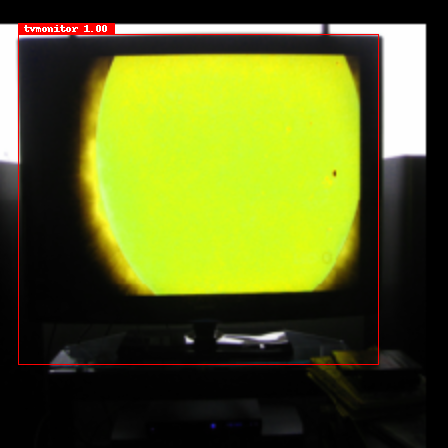

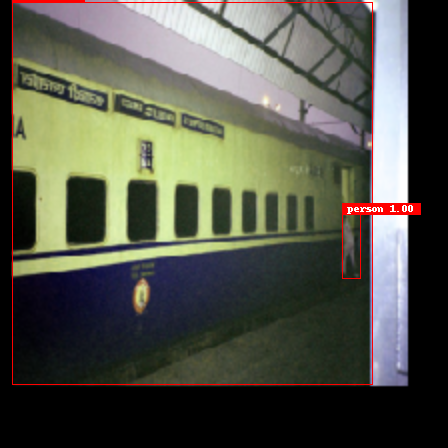

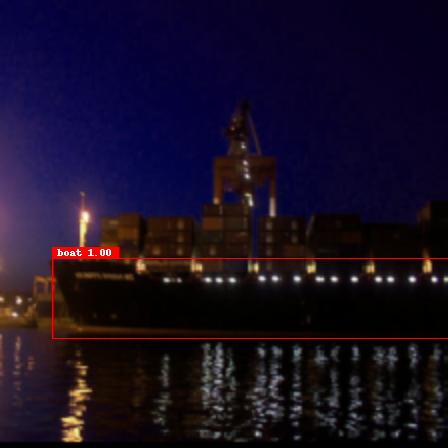

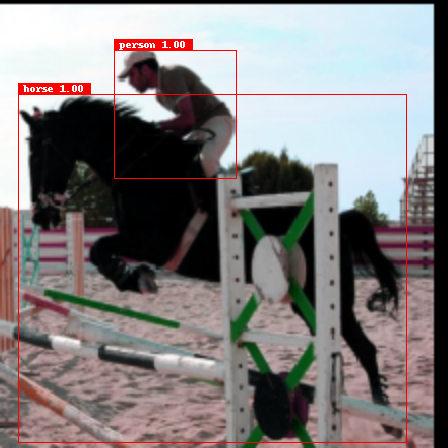

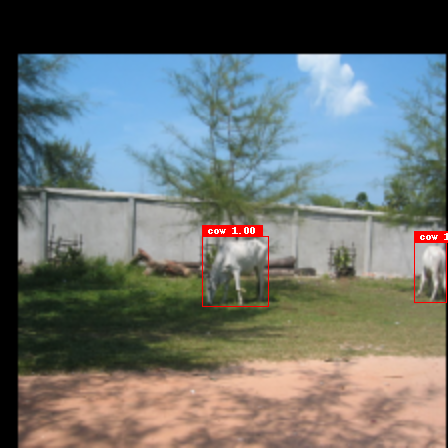

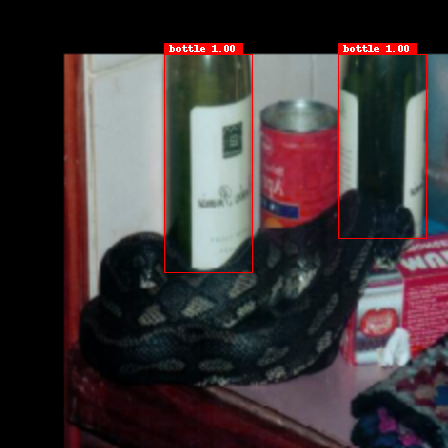

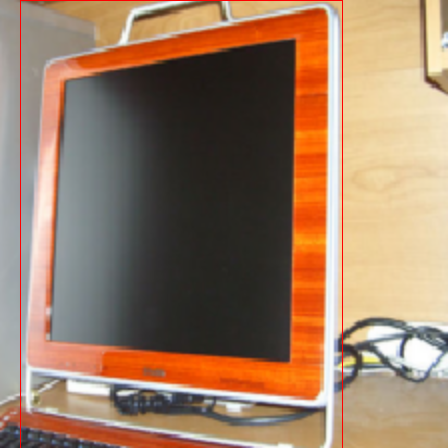

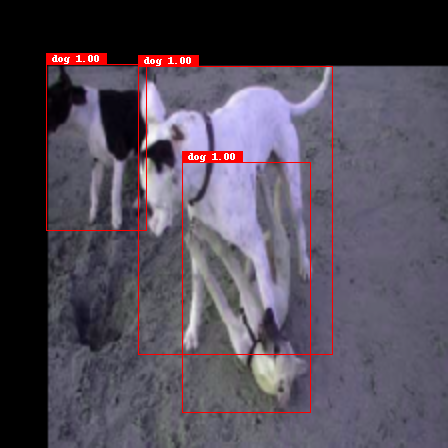

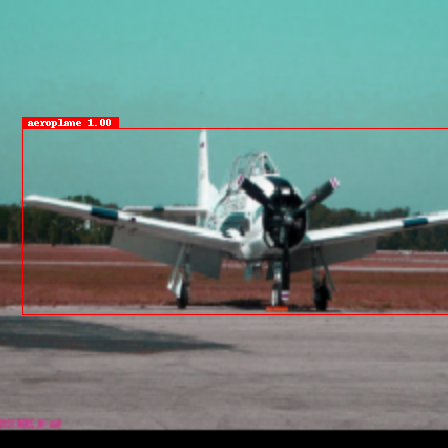

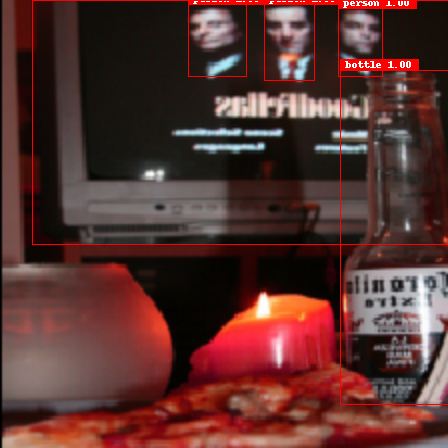

In [8]:
import numpy as np
from matplotlib import pyplot as plt

print('showing training images and boxes')
for i in range(10):
    images, bboxes = train_set[i]
    bboxes_ls, classes_ls, scores_ls = retrieve_bboxes(bboxes)
    visualize(images, bboxes_ls, classes_ls, scores_ls)

### Part 2: YOLO for Object Detection

In this section, we will be implementing the object detection architecture and algorithm used in the You Only Look Once (YOLO) paper. This paper introduced a fully convolutional network that takes in images and simultaneously predicts both bounding boxes and class probabilities, essentially turning object detection into a single regression problem.

**This section is pretty important. Please stop by office hours or post on Ed if you have questions about how "confidence" values work in YOLO.**

Based on the discussion of the data format above, we know that our model will spit out $B$ bounding box predictions for each cell during both training and inference time: if a cell contains an object, we need a way to designate which of those bounding boxes should be picked as the given object's "predictor". During inference time, we will use a technique called non-max suppression (which will be discussed later) but during training time, we will just pick the box that has the highest IOU with its corresponding ground truth bounding box.

This is also how we will define "confidence" in the context of YOLO: formally, the confidence value of a bounding box prediction is the IOU it gets with its corresponding ground truth box. This makes a lot of sense because:
* If there is no ground truth box that corresponds to a bounding box prediction (i.e. this bounding box prediction doesn't really correspond to anything and should be ignored), the IOU will be 0 and we would also like to predict a confidence value of 0 for this box.
* If there is a ground truth box that corresponds to a bounding box prediction, the confidence value will depend on the shape of the box. If
  - the box prediction has a very high overlap with the ground truth, it will achieve a high IOU and thus, we would like to predict a high confidence for this box
  - the box prediction has a low overlap with the ground truth, it will achieve a low IOU and we would also to predict a lower confidence value for this box

In a sense, this is encouraging a bounding box to predict its own IOU. This will be useful during inference time since we can then only pick boxes with high confidence values since they should hopefully correspond to more accurate predictions.

During training time, we would only like to penalize the bounding box that was designated as the "predictor" for an object among all predicted bounding box candidates within a cell and ignore the contribution of all other "frivolous" boxes to the YOLO loss objective. As such, we define a `box_mask` tensor of shape `(S, S, B)` such that `box_mask[i, j, k] = 1` if the `k`th bounding box in cell `(i, j)` is responsible for predicting an object and 0 otherwise.

Similarly, we can also define a `cell_mask` tensor of shape `(S, S)` such that `cell_mask[i, j] = 1` if cell `(i, j)` contains an object that is centered within it and, consequently, will also pick a designated "predictor" among its bounding box predictions for said object.

Clearly, we need a way to quickly compute the IOU between the predicted bounding boxes and the ground truth bounding boxes. Here is a helper function that we implemented for you that takes care of this computation!

You should read through the function below and try to understand it to the best of your ability. It contains certain hints for parts of the homework that you will have to implement yourself.

In [9]:
def batched_iou(preds, labels):
    """
    Compute the pairwise IOU between the predicted bounding boxes and the ground truth bounding boxes for each cell.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)

    returns: tensor of shape (N, S, S, B, B) containing the pairwise IOU between the predicted bounding boxes and the ground truth bounding boxes for each cell
    """
    N = labels.shape[0]

    x_labels, x_preds = labels[:, :, :, 1:5*B:5], preds[:, :, :, 1:5*B:5]
    y_labels, y_preds = labels[:, :, :, 2:5*B:5], preds[:, :, :, 2:5*B:5]
    w_labels, w_preds = labels[:, :, :, 3:5*B:5], preds[:, :, :, 3:5*B:5]
    h_labels, h_preds = labels[:, :, :, 4:5*B:5], preds[:, :, :, 4:5*B:5]

    cell_size = image_size / S
    # retrieve the coordinates of the bounding box rectangles for the labels
    x1_labels = cell_size * (x_labels + einops.repeat(torch.arange(S, device=labels.device), "S2 -> N S1 S2 B", N=N, S1=S, B=B)) - (image_size * w_labels / 2)
    y1_labels = cell_size * (y_labels + einops.repeat(torch.arange(S, device=labels.device), "S1 -> N S1 S2 B", N=N, S2=S, B=B)) - (image_size * h_labels / 2)
    x2_labels = x1_labels + image_size * w_labels
    y2_labels = y1_labels + image_size * h_labels
    # retrieve the coordinates of the bounding box rectangles for the predictions
    x1_preds = cell_size * (x_preds + einops.repeat(torch.arange(S, device=labels.device), "S2 -> N S1 S2 B", N=N, S1=S, B=B)) - (image_size * w_preds / 2)
    y1_preds = cell_size * (y_preds + einops.repeat(torch.arange(S, device=labels.device), "S1 -> N S1 S2 B", N=N, S2=S, B=B)) - (image_size * h_preds / 2)
    x2_preds = x1_preds + image_size * w_preds
    y2_preds = y1_preds + image_size * h_preds

    # compute the top left and bottom right corners of the rectangles
    tl_labels = torch.stack([x1_labels, y1_labels], dim=-1)
    br_labels = torch.stack([x2_labels, y2_labels], dim=-1)
    tl_preds = torch.stack([x1_preds, y1_preds], dim=-1)
    br_preds = torch.stack([x2_preds, y2_preds], dim=-1)

    # Largest top-left corner and smallest bottom-right corner give the intersection
    tl = torch.max(
        einops.repeat(tl_preds,  "N S1 S2 B1 D -> N S1 S2 B1 B2 D", B2=B),        # (N, S, S, B, 1, 2) -> (N, S, S, B, B, 2)
        einops.repeat(tl_labels, "N S1 S2 B2 D -> N S1 S2 B1 B2 D", B1=B)         # (N, S, S, 1, B, 2) -> (N, S, S, B, B, 2)
    )
    br = torch.min(
        einops.repeat(br_preds,  "N S1 S2 B1 D -> N S1 S2 B1 B2 D", B2=B),        # (N, S, S, B, 1, 2) -> (N, S, S, B, B, 2)
        einops.repeat(br_labels, "N S1 S2 B2 D -> N S1 S2 B1 B2 D", B1=B)         # (N, S, S, 1, B, 2) -> (N, S, S, B, B, 2)
    )

    intersection_sides = torch.clamp(br - tl, min=0.0)
    intersection = intersection_sides[..., 0] * intersection_sides[..., 1]       # (N, S, S, B, B)

    area_preds = (w_preds * image_size) * (h_preds * image_size)
    area_preds = einops.repeat(area_preds, "N S1 S2 B1 -> N S1 S2 B1 B2", B2=B)

    area_labels = (w_labels * image_size) * (h_labels * image_size)
    area_labels = einops.repeat(area_labels, "N S1 S2 B2 -> N S1 S2 B1 B2", B1=B)

    union = area_labels + area_preds - intersection

    # Add a small non-zero constant to avoid division-by-zero errors
    union += 1e-6

    return intersection / union

We also need a way to compute `cell_mask` and `box_mask` using the IOU between the ground truth and predicted bounding boxes: among all the bounding box predictions for a cell, we designate a box as a "predictor" for an object if it achieves the highest IOU with the corresponding ground truth box.

Again, we will provide helper functions that create these masks using the ground truth labels and model predictions.

In [10]:
def create_masks(preds, labels):
    """
    Create the cell and box masks based on the IOU.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    """
    N = labels.shape[0]

    iou = batched_iou(preds, labels) # (N, S, S, B, B)
    preds = preds[:, :, :, :5*B]
    labels = labels[:, :, :, :5*B]

    # iou[..., i, j] gives the IOU between ith prediction box and jth label box
    # take the max over all label boxes to get the cloest label box to a prediction box
    iou, _ = torch.max(iou, dim=-1) # (N, S, S, B)

    # 1 if bounding box is "responsible" for predicting the object
    responsible = torch.zeros(N, S, S, B, device=labels.device).scatter_(-1, torch.argmax(iou, dim=-1, keepdim=True), value=1)

    # 1 if cell contains an object and otherwise
    conf_labels = labels[:, :, :, 0::5] > 0.0
    cell_mask = conf_labels[..., 0]

    # 1 if box contains an object and is responsible for it
    box_mask = responsible * conf_labels

    return iou, cell_mask, box_mask

Now that we have uniquely formulated the object detection problem, we will introduce the loss function that YOLO optimizes. It has three components and we will step through each one:

**Classification Loss**: If a cell contains an object, we take the squared error between the class probabiities the model predicts for said cell vs the ground truth labels (which will be a one-hot vector). We add up this squared error for all cells that contain an object. Mathematically, this *classification loss* is given by
$$
l_{\text{classification}} = \sum_{i=0}^{S-1} \sum_{j=0}^{S-1} \mathbb 1_{ij}^{\text{obj}} \sum_{c \in \text{classes}} (p_{ij}(c) - \hat{p}_{ij}(c))^2
$$
where
* $\mathbb 1_{ij}^{\text{obj}}$ is $1$ if cell $(i, j)$ should detect an object, otherwise $0$ --- this is precisely the value given by `cell_mask[i, j]`
* $\hat{p}_{ij}(c)$ is the class probability, predicted by the model, of the object in cell $(i, j)$ belonging to class $c$
* $p_{ij}(c)$ is the class probability, according to the ground truth label, of the object in cell $(i, j)$ belonging to class $c$

In [11]:
def l_classification(preds, labels, cell_mask):
    """
    Compute the classification loss as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    param: cell_mask is a tensor of shape (N, S, S)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities

    Note: for the ground truth labels, the class probabilities will be one-hot encoded.
    """
    ## TODO: extract the (N, S, S, C) tensor of class probabilities from the labels
    class_labels = labels[..., -C:]
    ## TODO: extract the (N, S, S, C) tensor of class probabilities from the predictions
    class_preds = preds[..., -C:]
    ## TODO: compute the sum of the squared errors of the probabilities (hint: this should give you an (N, S, S) tensor)
    class_l = (class_preds - class_labels) ** 2
    ## TODO: apply the cell_mask to the the sum of the squared errors
    class_l = class_l * cell_mask.unsqueeze(-1)
    ## sum up the masked squared errors across along each grid cell across all N predictions in the batch
    return torch.sum(class_l)

**Localisation Loss**: If a bounding box is responsible for detecting an object, we take the squared error of its position and size predictions with respect to the true bounding box in the ground truth label. Remember that the problem of predicting an object's bounding box size and position is also known as object localization. As such, this loss component is also called *localization loss* and is given mathematically by:
$$
\begin{aligned}
l_{\text{localisation}} &= \sum_{i=0}^{S - 1} \sum_{j=0}^{S - 1} \sum_{k=0}^{B - 1} \mathbb 1_{ijk}^{\text{obj}} \left[(x_{ijk} - \hat{x}_{ijk})^2 + (y_{ijk} - \hat{y}_{ijk})^2 + \left( \sqrt{w_{ijk}} - \sqrt{\hat{w}_{ijk}} \right)^2 + \left( \sqrt{h_{ijk}} - \sqrt{\hat{h}_{ijk}} \right)^2 \right]
\end{aligned}
$$
where
* $\mathbb 1_{ijk}^{\text{obj}}$ is $1$ if the $k$th boundary box in cell $(i, j)$ is responsible for detecting the object, otherwise $0$ --- this is precisely the value given by `box_mask[i, j, k]`
* $(\hat{x}_{ijk}, \hat{y}_{ijk}, \hat{w}_{ijk}, \hat{h}_{ijk})$ are the center coordinates and spatial dimensions of the $k$th bounding box in cell $(i, j)$ according to the model predictions
* $(x_{ijk}, y_{ijk}, w_{ijk}, h_{ijk})$ are the center coordinates and spatial dimensions of the $k$th bounding box in cell $(i, j)$ according to the ground truth labels

In [12]:
def l_localization(preds, labels, box_mask):
    """
    Compute the localization loss as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    param: box_mask is a tensor of shape (N, S, S, B)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities
    """
    ## TODO: extract the (N, S, S, B) tensor of bounding box x-coordinates from the labels and predictions
    x_labels = labels[..., 1:2]
    x_preds = preds[..., 1:2]
    ## TODO: compute the squared errors between the x-coordinates (hint: this should give you an (N, S, S, B) tensor)
    x_l = (x_preds-x_labels)**2

    ## TODO: extract the (N, S, S, B) tensor of bounding box y-coordinates from the labels and predictions
    y_labels = labels[..., 2:3]
    y_preds = preds[..., 2:3]
    ## TODO: compute the squared errors between the y-coordinates (hint: this should give you an (N, S, S, B) tensor)
    y_l = (y_preds - y_labels) ** 2

    ## TODO: extract the (N, S, S, B) tensor of bounding box widths from the labels and predictions
    w_labels = labels[..., 3:4]
    w_preds = preds[..., 3:4]
    ## TODO: compute the squared errors between the square root of the widths (hint: this should give you an (N, S, S, B) tensor)
    w_l = (torch.sqrt(w_preds) - torch.sqrt(w_labels)) ** 2

    ## TODO: extract the (N, S, S, B) tensor of bounding box heights from the labels and predictions
    h_labels = labels[..., 4:5]
    h_preds = preds[..., 4:5]
    ## TODO: compute the squared errors between the square root of the heights (hint: this should give you an (N, S, S, B) tensor)
    h_l = (torch.sqrt(h_preds) - torch.sqrt(h_labels)) ** 2

    ## TODO: add the squared errors above to get the overall unmasked localization error per bounding box (hint: this should give you an (N, S, S, B) tensor)
    box_l = x_l + y_l + w_l + h_l
    ## TODO: apply the box_mask to box_l
    box_l = box_l * box_mask
    ## sum up the masked squared errors across along all bounding boxes along each grid cell across all N predictions in the batch
    return torch.sum(box_l)

**Confidence Loss**: We take the squared error between the confidence of each predicted box and its target confidence (this target is the IOU said box achieves with the corresponding ground truth bounding box if the box is designated as a predictor and 0 otherwise).

We compute two loss terms: the first term only contains the squared errors of the predicted boxes that are designated as responsible for bounding an object and the second term contains everything else. We return two terms because we want to weight the contribution of each term to the overall loss differently.
$$
\begin{aligned}
l_{\text{confidence_obj}} &= \sum_{i=0}^{S - 1} \sum_{j = 0}^{S - 1} \sum_{k=0}^B \mathbb 1_{ijk}^{\text{obj}} (s_{ijk} - \hat{s}_{ijk})^2 \\
l_{\text{confidence_no_obj}} &= \sum_{i=0}^{S - 1} \sum_{j = 0}^{S - 1} \sum_{k=0}^B \mathbb 1_{ijk}^{\text{no_obj}} (s_{ijk} - \hat{s}_{ijk})^2
\end{aligned}
$$
where
* $\hat{s}_{ijk}$ is the box confidence score of the $k$th box in cell $(i, j)$ and $s_{ijk}$ is the IOU it is trying to predict, as mentioned at the beginning of this section
* $\mathbb 1_{ijk}^{\text{obj}}$ is $1$ if the $k$th boundary box in cell $(i, j)$ is responsible for detecting the object, otherwise $0$ --- this is precisely the value given by `box_mask[i, j, k]`
* $\mathbb 1_{ij}^{\text{no_obj}} = 1 - \mathbb 1_{ij}^{\text{obj}}$ is the complement of $1_{ij}^{\text{obj}}$



In [13]:
def l_confidence(preds, ious, box_mask):
    """
    Compute both confidence loss terms as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: ious is a tensor of shape (N, S, S, B)
    param: box_mask is a tensor of shape (N, S, S, B)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities
    """
    ## TODO: extract the (N, S, S, B) tensor of bounding box confidence scores from the predictions
    s_preds = preds[..., :5 * B:5]

    ## TODO: compute the squared errors between the confidence scores and the ious (hint: this should give you an (N, S, S, B) tensor)
    s_l_obj = (s_preds - ious) ** 2
    ## TODO: compute the squared errors between the confidence scores and a zero tensor in the shape of ious (hint: look into torch.zeros_like(...))
    s_l_no_obj = (s_preds - torch.zeros_like(ious)) ** 2

    s_l_obj = s_l_obj * box_mask
    s_l_no_obj = s_l_no_obj * (1 - box_mask)

    return torch.sum(s_l_obj), torch.sum(s_l_no_obj)

We can now compute the overall loss as the weighted sum of each of the loss terms above:
$$
\begin{aligned}
l = l_{\text{classification}} + \lambda_{\text{coord}} l_{\text{localization}} + l_{\text{confidence_obj}} + \lambda_{\text{no_obj}}l_{\text{confidence_no_obj}}
\end{aligned}
$$
where
* $\lambda_{\text{coord}}$ is some hyperparameter that scales the contribution of the localization loss to the overall loss term. In this case, we set it to $5$ to **increase** the weight of this loss term since predicting accurate bounding box coordinates is very important in object detection.

* $\lambda_{\text{no_obj}}$ is used to **decrease** the weight when detecting the background (i.e. boxes not resposible for predicting an object) instead of an object

We will also return each of the 3 loss components above so we can log them during training.

In [14]:
def yolo_loss(preds, labels, lambda_coord=5, lambda_no_obj=0.5):
    with torch.no_grad():
        ious, cell_mask, box_mask = create_masks(preds, labels)

    class_l = l_classification(preds, labels, cell_mask)
    local_l = lambda_coord * l_localization(preds, labels, box_mask)
    conf_l_obj, conf_l_no_obj = l_confidence(preds, ious, box_mask)
    conf_l = conf_l_obj + lambda_no_obj * conf_l_no_obj

    return class_l + local_l + conf_l, class_l, local_l, conf_l

Cool! Now that we have the YOLO objective defined, let's also go ahead and define our standard training loop that you have seen in HW 2A and HW 1.

In [15]:
def eval(model, criterion, loader):
    total_overall_loss = 0
    total_class_loss = 0
    total_local_loss = 0
    total_conf_loss = 0

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for imgs, labels in tqdm(loader, leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()
    total_items = len(loader.dataset)
    return total_overall_loss / total_items, total_class_loss / total_items, total_local_loss / total_items, total_conf_loss / total_items


def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)

    model = model.to(device)

    best_val_loss = float('inf')

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_overall_loss = 0
        total_class_loss = 0
        total_local_loss = 0
        total_conf_loss = 0
        start_time = time.perf_counter()

        for i, (inputs, labels) in enumerate(tqdm(train_loader, leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            overall_loss.backward()
            optimizer.step()
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()

        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')

        end_time = time.perf_counter()
        duration = end_time - start_time

        total_items = len(train_loader.dataset)
        train_overall_loss = total_overall_loss / total_items
        train_class_loss = total_class_loss / total_items
        train_local_loss = total_local_loss / total_items
        train_conf_loss = total_conf_loss / total_items
        valid_overall_loss, valid_class_loss, valid_local_loss, valid_conf_loss = eval(model, criterion, val_loader)

        if valid_overall_loss < best_val_loss:
            best_val_loss = valid_overall_loss
            if path:
                torch.save(model.state_dict(), f'{path}/best_model.pth')

        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 1e-4:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'time: {duration:.3f}',
              f'lr: {current_lr:.3e}',
              '\n',
              f'train loss (overall): {train_overall_loss:08.4f}',
              f'valid loss (overall): {valid_overall_loss:08.4f}',
              '\n',
              f'train loss (class):   {train_class_loss:08.4f}',
              f'valid loss (class):   {valid_class_loss:08.4f}',
              '\n',
              f'train loss (local):   {train_local_loss:08.4f}',
              f'valid loss (local):   {valid_local_loss:08.4f}',
              '\n',
              f'train loss (conf):    {train_conf_loss:08.4f}',
              f'valid loss (conf):    {valid_conf_loss:08.4f}')

This is where we define the actual YOLO architecture. Recall from the Deep Learning 3 and CNN lectures that it is possible to leverage pre-trained convolutional neural networks for their learned representations when working on a new computer vision task. This is actually a pretty common practice in object detection where you leverage the representations learned by an image classification model. We call this pre-trained model the `feature backbone` for our object detection model since we use it to extract relevant features from an input image. This is the first example of transfer learning you have seen in this course.

These features are then passed into what we call a `task-specific head`: this is the set of learnable layers that maps the pre-trained features from the feature backbone to the output for our downstream task. In the cell below, we define the task-specific head for our object detection model, which will just be a bunch of convolutional layers followed by a couple of linear layers whose output is then reshaped to the data format we described above. This head, combined with the feature backbone, comprises the entire YOLO model.


YOLO has undergone many iterations over the years but all of them use some sort of feature backbone and object-detection head (the differences lie in how these backbones/heads are implemented and trained).
For more information on YOLO and its later iterations, check out this really cool and detailed [blog post](https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088#:~:text=YOLO%20uses%20sum%2Dsquared%20error,box%20and%20the%20ground%20truth).

In [16]:
class YOLO(nn.Module):
    def __init__(self, backbone, backbone_channels):
        """
        We take as input some feature backbone whose features are passed
        into the custom layers we define below.

        The output of this network should be a tensor of shape (S, S, 5B + C)
        so we train a linear layer that outputs a tensor of shape S * S * (5B + C)
        instead. We then reshape it at the end.
        """
        X = S * S * (5 * B + C)

        super().__init__()
        self.backbone = backbone

        self.conv1 = nn.Conv2d(backbone_channels, 512, 3, 1, 1)
        self.conv2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv3 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv4 = nn.Conv2d(512, 512, 3, 1, 1)

        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (S, S, 5 * B + C))
        self.linear1 = nn.Linear(512 * (image_size // 32) ** 2, 4096)
        self.linear2 = nn.Linear(4096, X)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.leaky_relu(self.conv3(x), 0.1)
        x = F.leaky_relu(self.conv4(x), 0.1)
        x = self.flatten(x)
        x = F.leaky_relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.unflatten(x)
        x = F.sigmoid(x)

        return x

We will use a ResNet-50 pre-trained on ImageNet for our feature backbone. We could use the ResNet backbone that we trained ourselves on CIFAR-10 in HW 2A, but it will likely not yield very high quality features. Remember that large models trained on large and diverse datasets tend to learn more generalizable and useful features (the ImageNet dataset contains 1.3M images distributed across 1000 semantic categories while the CIFAR-10 dataset only contains 50,000 images distributed across 10 classes). That said, after you have finished this assignment, you could give your custom ResNet model from HW 2A a shot and see how it's performance compares against the ImageNet pre-trained backbone!

Just like `torchvision` stores a bunch of popular CV datasets that can be downloaded as necessary, it also the hub to many popular CNN architectures and their pre-trained weights. We will use it to download the pre-trained ResNet model mentioned above.

In [17]:
resnet = models.resnet50(weights='DEFAULT')
resnet_channels = resnet.fc.in_features
resnet = torch.nn.Sequential(*list(resnet.children())[:-2])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


Now define the model and print out its summary. We will use `torchsummary` (we could also use another module called `torchinfo`) which is a pretty nifty tool that prints out the shape of your input as it traverses through your neural network. This can be a very useful debugging tool and we use it ensure that the model input and output shapes match up with what we expect. For example, if we pass a `3 x 224 x 224` image into our model, we can see that the final output will have a shape of `7 x 7 x 30`, which is precisely what we want!

In [18]:
yolonet = YOLO(resnet, resnet_channels)
yolonet = yolonet.to(device)
summary(yolonet, (3, 224, 224)) # Each (unbatched) input to the model will be a 3 x 224 x 224 image

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Note that `torchsummary` also tells you how big your model is. For example, we can see that the YOLO model we defined has 148 million parameters: this is a massive model! Turns out most of these parameters come from the 2 linear layers at the end. However, as you might have learned from HW 2A, this is not completely surprising to us; convolutional layers don't have too many parameters because of their inherent weight sharing.

Now, we can finally start training! Feel free to change the hyperparameters down below but we don't think you will need to.

In [19]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

In [20]:
num_epochs = 30
criterion = yolo_loss
optimizer = optim.Adam(yolonet.parameters(), lr=1e-4)

Once you are confident that you implemented the loss functions above correctly, pleast switch to a GPU runtime. While you are debugging your implementation, we would suggest sticking to a CPU runtime so you don't use up your GPU quotas without even getting a change to properly train your model.

A single epoch should take roughly ~3 minutes on the GPU Colab provides. By default, we have set the number of epochs to 30 so it will take around 1 hour 30 minutes to train this model. That said, you can probably reduce the number of epochs down to, say, 15-20, and still get a good enough model to pass this homework's threshold.

In [21]:
train(yolonet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_yolo')

beginning to train model


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  1 time: 169.648 lr: 1.000e-04 
 train loss (overall): 006.5088 valid loss (overall): 005.5539 
 train loss (class):   002.5518 valid loss (class):   002.3429 
 train loss (local):   003.2818 valid loss (local):   002.6819 
 train loss (conf):    000.6752 valid loss (conf):    000.5291


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  2 time: 184.559 lr: 1.000e-04 
 train loss (overall): 005.0104 valid loss (overall): 005.0860 
 train loss (class):   001.9953 valid loss (class):   002.1273 
 train loss (local):   002.5031 valid loss (local):   002.4018 
 train loss (conf):    000.5119 valid loss (conf):    000.5569


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  3 time: 167.463 lr: 1.000e-04 
 train loss (overall): 004.5030 valid loss (overall): 004.7769 
 train loss (class):   001.7809 valid loss (class):   001.9816 
 train loss (local):   002.2109 valid loss (local):   002.2597 
 train loss (conf):    000.5112 valid loss (conf):    000.5356


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  4 time: 170.534 lr: 1.000e-04 
 train loss (overall): 004.1078 valid loss (overall): 004.5094 
 train loss (class):   001.6620 valid loss (class):   001.8546 
 train loss (local):   001.9492 valid loss (local):   002.1093 
 train loss (conf):    000.4966 valid loss (conf):    000.5455


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  5 time: 168.142 lr: 1.000e-04 
 train loss (overall): 003.7987 valid loss (overall): 004.1192 
 train loss (class):   001.5232 valid loss (class):   001.6773 
 train loss (local):   001.7916 valid loss (local):   001.9312 
 train loss (conf):    000.4838 valid loss (conf):    000.5106


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  6 time: 161.279 lr: 1.000e-04 
 train loss (overall): 003.5316 valid loss (overall): 003.9813 
 train loss (class):   001.3749 valid loss (class):   001.5574 
 train loss (local):   001.6855 valid loss (local):   001.9088 
 train loss (conf):    000.4712 valid loss (conf):    000.5152


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  7 time: 168.128 lr: 1.000e-04 
 train loss (overall): 003.3071 valid loss (overall): 003.8207 
 train loss (class):   001.2507 valid loss (class):   001.4685 
 train loss (local):   001.5917 valid loss (local):   001.8379 
 train loss (conf):    000.4648 valid loss (conf):    000.5143


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  8 time: 167.407 lr: 1.000e-04 
 train loss (overall): 003.1254 valid loss (overall): 003.6739 
 train loss (class):   001.1494 valid loss (class):   001.3561 
 train loss (local):   001.5135 valid loss (local):   001.8056 
 train loss (conf):    000.4625 valid loss (conf):    000.5123


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch  9 time: 174.945 lr: 1.000e-04 
 train loss (overall): 002.9558 valid loss (overall): 003.6002 
 train loss (class):   001.0397 valid loss (class):   001.2844 
 train loss (local):   001.4623 valid loss (local):   001.8027 
 train loss (conf):    000.4537 valid loss (conf):    000.5131


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 10 time: 166.842 lr: 1.000e-04 
 train loss (overall): 002.8201 valid loss (overall): 003.4685 
 train loss (class):   000.9605 valid loss (class):   001.2078 
 train loss (local):   001.4107 valid loss (local):   001.7603 
 train loss (conf):    000.4489 valid loss (conf):    000.5004


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 11 time: 165.362 lr: 1.000e-04 
 train loss (overall): 002.6707 valid loss (overall): 003.4063 
 train loss (class):   000.8755 valid loss (class):   001.1557 
 train loss (local):   001.3542 valid loss (local):   001.7537 
 train loss (conf):    000.4411 valid loss (conf):    000.4970


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 12 time: 161.943 lr: 1.000e-04 
 train loss (overall): 002.5421 valid loss (overall): 003.2959 
 train loss (class):   000.8068 valid loss (class):   001.1064 
 train loss (local):   001.2970 valid loss (local):   001.7017 
 train loss (conf):    000.4383 valid loss (conf):    000.4878


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 13 time: 164.895 lr: 1.000e-04 
 train loss (overall): 002.4438 valid loss (overall): 003.2604 
 train loss (class):   000.7471 valid loss (class):   001.0542 
 train loss (local):   001.2648 valid loss (local):   001.7180 
 train loss (conf):    000.4320 valid loss (conf):    000.4882


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 14 time: 169.387 lr: 1.000e-04 
 train loss (overall): 002.3672 valid loss (overall): 003.2198 
 train loss (class):   000.6981 valid loss (class):   001.0363 
 train loss (local):   001.2433 valid loss (local):   001.6878 
 train loss (conf):    000.4259 valid loss (conf):    000.4956


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 15 time: 170.726 lr: 1.000e-04 
 train loss (overall): 002.2927 valid loss (overall): 003.1799 
 train loss (class):   000.6623 valid loss (class):   001.0210 
 train loss (local):   001.2125 valid loss (local):   001.6675 
 train loss (conf):    000.4178 valid loss (conf):    000.4914


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 16 time: 171.367 lr: 1.000e-04 
 train loss (overall): 002.2190 valid loss (overall): 003.1603 
 train loss (class):   000.6268 valid loss (class):   000.9968 
 train loss (local):   001.1743 valid loss (local):   001.6840 
 train loss (conf):    000.4179 valid loss (conf):    000.4795


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 17 time: 168.335 lr: 1.000e-04 
 train loss (overall): 002.1503 valid loss (overall): 003.0940 
 train loss (class):   000.5949 valid loss (class):   000.9748 
 train loss (local):   001.1455 valid loss (local):   001.6452 
 train loss (conf):    000.4098 valid loss (conf):    000.4740


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 18 time: 168.529 lr: 1.000e-04 
 train loss (overall): 002.1059 valid loss (overall): 003.1096 
 train loss (class):   000.5738 valid loss (class):   000.9657 
 train loss (local):   001.1202 valid loss (local):   001.6687 
 train loss (conf):    000.4120 valid loss (conf):    000.4752


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 19 time: 162.739 lr: 1.000e-04 
 train loss (overall): 002.0471 valid loss (overall): 003.1117 
 train loss (class):   000.5521 valid loss (class):   000.9887 
 train loss (local):   001.0915 valid loss (local):   001.6451 
 train loss (conf):    000.4034 valid loss (conf):    000.4778


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 20 time: 171.437 lr: 1.000e-04 
 train loss (overall): 002.0067 valid loss (overall): 003.0753 
 train loss (class):   000.5330 valid loss (class):   000.9637 
 train loss (local):   001.0725 valid loss (local):   001.6338 
 train loss (conf):    000.4012 valid loss (conf):    000.4778


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 21 time: 166.511 lr: 1.000e-04 
 train loss (overall): 001.9696 valid loss (overall): 003.0853 
 train loss (class):   000.5146 valid loss (class):   000.9501 
 train loss (local):   001.0592 valid loss (local):   001.6573 
 train loss (conf):    000.3957 valid loss (conf):    000.4779


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 22 time: 169.265 lr: 1.000e-04 
 train loss (overall): 001.9255 valid loss (overall): 003.0643 
 train loss (class):   000.5005 valid loss (class):   000.9450 
 train loss (local):   001.0294 valid loss (local):   001.6437 
 train loss (conf):    000.3956 valid loss (conf):    000.4756


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 23 time: 163.174 lr: 1.000e-04 
 train loss (overall): 001.8635 valid loss (overall): 003.0351 
 train loss (class):   000.4794 valid loss (class):   000.9481 
 train loss (local):   001.0002 valid loss (local):   001.6119 
 train loss (conf):    000.3839 valid loss (conf):    000.4751


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 24 time: 171.666 lr: 1.000e-04 
 train loss (overall): 001.8413 valid loss (overall): 002.9934 
 train loss (class):   000.4602 valid loss (class):   000.9228 
 train loss (local):   000.9983 valid loss (local):   001.6089 
 train loss (conf):    000.3828 valid loss (conf):    000.4617


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 25 time: 169.459 lr: 1.000e-04 
 train loss (overall): 001.7914 valid loss (overall): 002.9965 
 train loss (class):   000.4416 valid loss (class):   000.9144 
 train loss (local):   000.9671 valid loss (local):   001.6151 
 train loss (conf):    000.3828 valid loss (conf):    000.4670


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 26 time: 168.402 lr: 1.000e-04 
 train loss (overall): 001.7721 valid loss (overall): 002.9751 
 train loss (class):   000.4368 valid loss (class):   000.9079 
 train loss (local):   000.9564 valid loss (local):   001.6077 
 train loss (conf):    000.3789 valid loss (conf):    000.4595


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 27 time: 163.955 lr: 1.000e-04 
 train loss (overall): 001.7445 valid loss (overall): 002.9721 
 train loss (class):   000.4322 valid loss (class):   000.9095 
 train loss (local):   000.9357 valid loss (local):   001.6055 
 train loss (conf):    000.3767 valid loss (conf):    000.4571


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 28 time: 167.113 lr: 1.000e-04 
 train loss (overall): 001.7119 valid loss (overall): 002.9634 
 train loss (class):   000.4116 valid loss (class):   000.9018 
 train loss (local):   000.9252 valid loss (local):   001.6018 
 train loss (conf):    000.3751 valid loss (conf):    000.4597


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 29 time: 171.099 lr: 1.000e-04 
 train loss (overall): 001.6912 valid loss (overall): 002.9498 
 train loss (class):   000.4089 valid loss (class):   000.8940 
 train loss (local):   000.9102 valid loss (local):   001.5986 
 train loss (conf):    000.3720 valid loss (conf):    000.4573


  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


epoch 30 time: 169.503 lr: 1.000e-04 
 train loss (overall): 001.6630 valid loss (overall): 002.9495 
 train loss (class):   000.3918 valid loss (class):   000.9052 
 train loss (local):   000.9030 valid loss (local):   001.5875 
 train loss (conf):    000.3682 valid loss (conf):    000.4568


# Part 3: Non-Max Suppression

Before we visualize our model's predictions, let's reload the best checkpoint.

In [22]:
yolonet.load_state_dict(torch.load('./checkpoints_yolo/best_model.pth'))

<All keys matched successfully>

When we visualize our model's predictions, we will use a technique called non-max supression. Remember that a model will predict up to $S \times S \times B = S^2B$ boxes for a single image: certainly not all of them will contain an object! We could try to filter out some boxes based on their confidence value.
However, how do we choose a confidence threshold? There will likely be multiple boxes on each object if our confidence threshold is too low. On the other hand, if our confidence threshold is too high then some objects won't even be found.

Non-max supression solves this problem. First we filter by setting a low(ish) confidence threshold to get most of the boxes which are around some kind of object (but we still have too many boxes and some boxes will be more or less accurate than others). Now, our goal is to get rid of duplicate boxes around an object. Then we apply non-max supression as follows:

Start with the box of highest confidence. Compute the IOU of that box with all other boxes. If the IOU is above some threshold, eliminate that box. Continue to the next highest box confidence and repeat.

This algorithm gets rid of similar boxes leaving behind only the highest confidence box for each object. Fortunately, `torchvision` already has a function that performs this process for us and we will use it to generate model visualizations on the validation set below.

In the cell below, we first manually filter out all boxes with a confidence less than `conf_threshold` (which has a value of 0.2) and then perform NMS with an IOU threshold of `nms_threshold` (which currently has a value of 0.5). We were able to get decent visualizations with these thresholds but feel free to change them as you see fit!

In [23]:
conf_threshold = 0.2
nms_threshold = 0.5

In [24]:
def nms_visualize(model, loaded):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        imgs, _ = loaded
        imgs = imgs.to(device)

        outputs = model(imgs)
    img, label = imgs[0], outputs[0]

    model.train()

    filtered_boxes, filtered_classes, filtered_scores = nms_best(label)

    visualize(img, filtered_boxes, filtered_classes, filtered_scores)

def nms_best(preds):
    preds = preds.to("cpu").reshape((S, S, 5 * B + C))

    boxes_ls, classes_ls, scores_ls = [], [], []

    for sy in range(S):
        for sx in range(S):
            cell = preds[sy][sx]
            for b in range(B):
                box = preds[sy][sx][5*b:5*(b+1)]
                if box[0] >= conf_threshold:
                    scores_ls.append(box[0])

                    class_probs = cell[5*B:]
                    class_num = torch.argmax(class_probs)
                    class_label = classes[class_num]
                    classes_ls.append(class_label)

                    cell_size = image_size / S

                    y1 = cell_size * (sy + box[2]) - (image_size * box[4] / 2)
                    x1 = cell_size * (sx + box[1]) - (image_size * box[3] / 2)
                    y2 = y1 + image_size * box[4]
                    x2 = x1 + image_size * box[3]

                    xyxy = [x1, y1, x2, y2]

                    boxes_ls.append(xyxy)

    boxes_ls = torch.tensor(boxes_ls)
    scores_ls = torch.tensor(scores_ls)

    filtered_preds = torchvision.ops.nms(boxes_ls, scores_ls, nms_threshold)

    return boxes_ls[filtered_preds], [classes_ls[i] for i in filtered_preds], scores_ls[filtered_preds]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


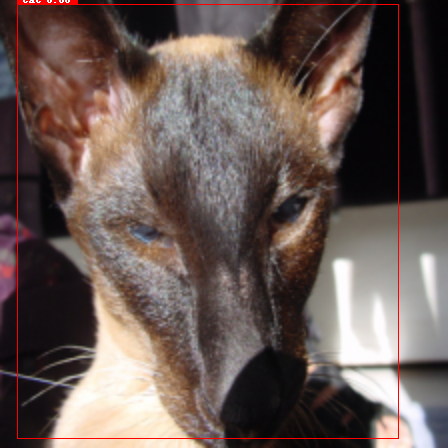

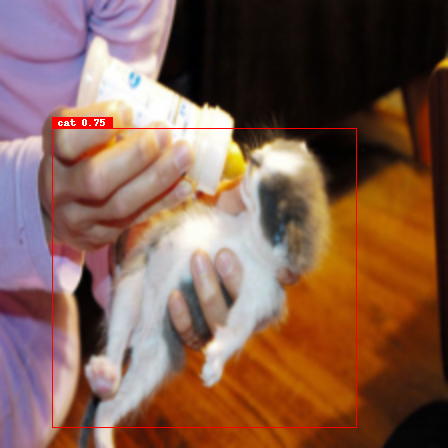

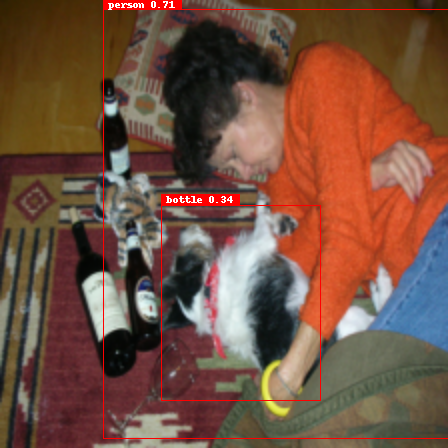

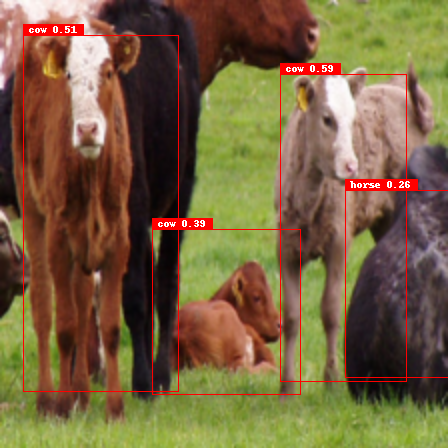

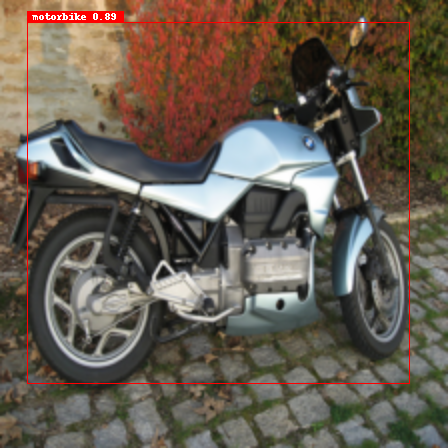

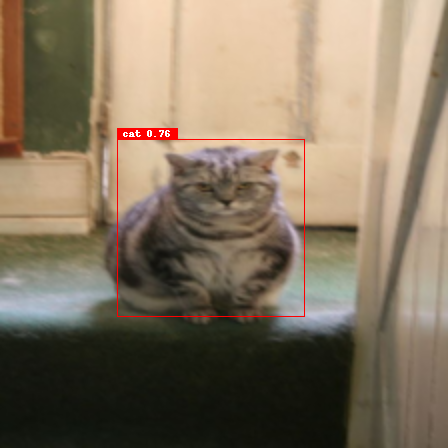

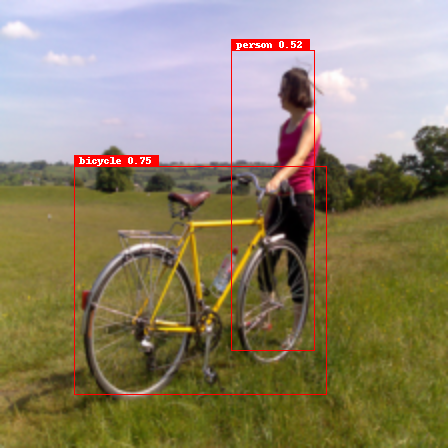

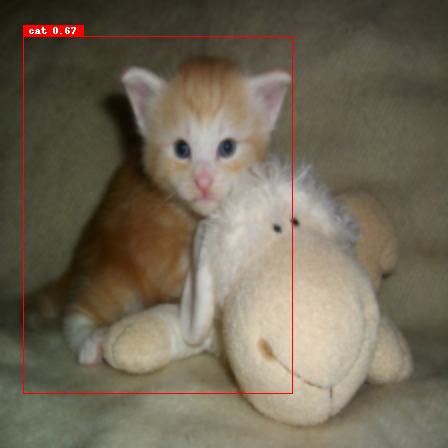

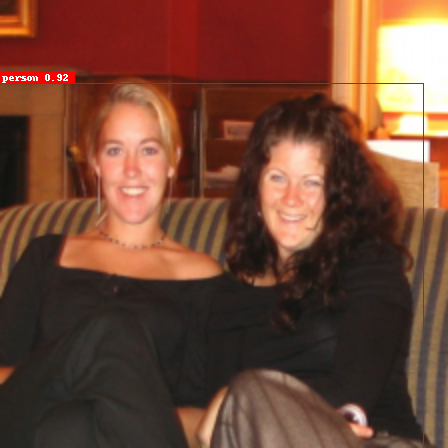

In [25]:
vli = iter(val_loader)

for _ in range(10):
    nms_visualize(yolonet, next(vli))

# Part 4: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a csv file that will contain your model's predictions on the some subset of samples from the Pascal VOC validation set --- tampering with the code blocks below might mess up the file that you will submit to the Gradescope autograder.

In [26]:
test_set = torch.utils.data.Subset(val_set, range(1000))
test_batch_size = 64
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

In [27]:
cell_size = image_size / S

labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
          'bus', 'car', 'cat', 'chair', 'cow',
          'diningtable', 'dog', 'horse', 'motorbike', 'person',
          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [28]:
if os.path.isfile("YOLO_predictions.csv"):
    os.remove("YOLO_predictions.csv")

yolonet.eval()
with open("YOLO_predictions.csv", "w") as f:
    f.write(f"data_num,class_label,class_num,x1,y1,x2,y2\n")
    for i, batch in enumerate(test_loader):
        imgs, _ = batch
        imgs = imgs.to(device)
        with torch.no_grad():
            preds = yolonet(imgs)

        for j, pred in enumerate(preds):
            boxes_ls, scores_ls, class_label_ls, class_num_ls = [], [], [], []
            for sy in range(S):
                for sx in range(S):
                    cell = pred[sy][sx]
                    for b in range(B):
                        if cell[5 * b] > conf_threshold:
                            cell_size = image_size / S

                            class_num = torch.argmax(cell[5*B:])
                            class_label = labels[class_num]
                            class_num_ls.append(class_num)
                            class_label_ls.append(class_label)

                            y1 = cell_size * (sy + cell[5 * b + 2]) - (image_size * cell[5 * b + 4] / 2)
                            x1 = cell_size * (sx + cell[5 * b + 1]) - (image_size * cell[5 * b + 3] / 2)
                            y2 = y1 + image_size * cell[5 * b + 4]
                            x2 = x1 + image_size * cell[5 * b + 3]

                            xyxy = [x1, y1, x2, y2]

                            scores_ls.append(cell[5 * b])
                            boxes_ls.append(xyxy)

            boxes_ls, scores_ls = torch.tensor(boxes_ls), torch.tensor(scores_ls)
            if len(boxes_ls) == 0:
                continue
            filtered_preds = torchvision.ops.nms(boxes_ls, scores_ls, nms_threshold)
            for idx in filtered_preds:
                x1, y1, x2, y2 = boxes_ls[idx]
                class_label, class_num = class_label_ls[idx], class_num_ls[idx]
                f.write(f"{i*test_batch_size + j}, {class_label}, {class_num}, {x1}, {y1}, {x2}, {y2} \n")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
